In [ ]:
import os
import json
JUDGE_ROOT = "../result/analysis/judge"
def aggregate_metrics(judge_root, context_on, output_filename):
    subfolder = "with-con" if context_on else "without-con"
    base_dir = os.path.join(judge_root, subfolder)
    result = []

    for model_name in os.listdir(base_dir):
        model_dir = os.path.join(base_dir, model_name)
        metrics_path = os.path.join(model_dir, "metrics_output.json")

        if not os.path.isdir(model_dir) or not os.path.isfile(metrics_path):
            continue

        try:
            with open(metrics_path, "r") as f:
                metrics_data = json.load(f)
                model_entry = {
                    "model": model_name,
                    "data": metrics_data.get("data", []),
                    "header": metrics_data.get("header", [])
                }
                result.append(model_entry)
        except Exception as e:
            print(f"Failed to load or parse {metrics_path}: {e}")

    try:
        with open(output_filename, "w") as out_f:
            json.dump(result, out_f, indent=4)
        print(f"Successfully wrote aggregated metrics to {output_filename}")
    except Exception as e:
        print(f"Error writing to {output_filename}: {e}")


In [ ]:
aggregate_metrics(JUDGE_ROOT, context_on=1, output_filename="parsed_data_with_con.json")
aggregate_metrics(JUDGE_ROOT, context_on=0, output_filename="parsed_data_without_con.json")

# F1

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D
import numpy as np
from collections import defaultdict
import json

plt.rcParams.update({
    "font.family": 'Candara',
    "font.size": 8,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.titleweight": "bold",
})


model_map = {
    "r1-qn-7b": {"size": 7, "reasoning": True, "family": "Qwen"},
    "r1-qn-14b": {"size": 14, "reasoning": True, "family": "Qwen"},
    "r1-qn-32b": {"size": 32, "reasoning": True, "family": "Qwen"},
    "r1-lm-8b": {"size": 9, "reasoning": True, "family": "Llama"},
    "r1-lm-70b": {"size": 70, "reasoning": True, "family": "Llama"},
    "qn-7b": {"size": 7, "reasoning": False, "family": "Qwen"},
    "qn-14b": {"size": 14, "reasoning": False, "family": "Qwen"},
    "qn-32b": {"size": 32, "reasoning": False, "family": "Qwen"},
    "qn3-32b": {"size": 32, "reasoning": True, "family": "Qwen", "special": True},
    "qn3-32b-0": {"size": 32, "reasoning": False, "family": "Qwen", "special": True},
    "lm-8b": {"size": 9, "reasoning": False, "family": "Llama"},
    "lm-70b": {"size": 70, "reasoning": False, "family": "Llama"},
    "ds-v3": {"size": 671, "reasoning": False, "family": "DeepSeek", "special": True},
    "ds-r1": {"size": 671, "reasoning": True, "family": "DeepSeek", "special": True},
    "4o": {"size": 800, "reasoning": None, "family": "OpenAI", "special": True},
}

COLOR_MAP = {
    ("Qwen", True): "#466FA8",    
    ("Qwen", False): "#90B4DC",   
    ("Llama", False): "#E68C85",  
    ("Llama", True): "#F7C6C3",    
}

SPECIAL_MARKERS_COLORS = {
    "ds-r1": ("P", "#6FA18E"),      # DeepSeek-R1
    "ds-v3": ("D", "#B0D8D5"),      # DeepSeek-V3
    "4o": ("X", "#A3AAAF"),         # GPT-4o
    "qn3-32b": ("^", "#5C7497"),    # Qwen3 [R]
    "qn3-32b-0": ("v", "#9ABFDB"),  # Qwen3 [NR]
}

def compress_model_size(size):
    return {671: 100, 800: 120}.get(size, size)

def prepare_plot_data(parsed_data, model_map):
    cwe_metrics = defaultdict(lambda: defaultdict(dict))
    special_models_data = defaultdict(lambda: defaultdict(dict))

    for model_data in parsed_data:
        model_name = model_data["model"]
        if model_name not in model_map:
            continue
        info = model_map[model_name]
        size = info["size"]
        family = info["family"]
        reasoning = info["reasoning"]
        special = info.get("special", False)
        if size is None:
            continue
        for row in model_data["data"]:
            if len(row) < 6:
                continue
            try:
                cwe_id = int(row[0].split("-")[1])
                if cwe_id in [435, 697]:
                    continue
                # row[1] is total instances for this CWE
                # row[5] is pair accuracy rate for this CWE
                
                recall = float(row[2])
                accuracy = float(row[3])
                f1 = float(row[4])
                pair_accuracy_rate = float(row[5]) # This is the rate

                if special:
                    special_models_data[cwe_id][model_name] = {
                        "recall": recall, "accuracy": accuracy, "f1": f1,
                        "pair_accuracy_rate": pair_accuracy_rate,
                        "total_instances": float(row[1]), # Store total instances
                        "size": size, "family": family, "reasoning": reasoning,
                    }
                else:
                    cwe_metrics[(family, reasoning)][cwe_id][size] = { 
                        "recall": recall, "accuracy": accuracy, "f1": f1,
                        "pair_accuracy_rate": pair_accuracy_rate,
                        "total_instances": float(row[1]), # Store total instances
                    }
            except Exception as e:
                # print(f"Error parsing row for model {model_name}: {row} - {e}")
                continue
    return {"param_data": dict(cwe_metrics), "special_data": dict(special_models_data)}

def draw_cwe_subplot_combined(
    ax, cwe_id, metric, param_data_with, special_data_with,
    param_data_without, special_data_without, title,
    show_xlabel, show_ylabel=False, fontsize=10,
):
    for (family, reasoning), family_data in param_data_with.items():
        if cwe_id not in family_data or (family == "Llama" and reasoning): # Llama [R] is not in original dataset
            continue
        data = family_data[cwe_id]
        points = sorted((compress_model_size(s), data[s][metric]) for s in data)
        sizes, values = zip(*points)
        color = COLOR_MAP.get((family, reasoning), "#999999")
        marker = "o" if family == "Llama" else "s"
        ax.plot(sizes, values, "-", color=color, marker=marker, markersize=4, linewidth=1.2)

    for (family, reasoning), family_data in param_data_without.items():
        if cwe_id not in family_data or (family == "Llama" and reasoning): # Llama [R] is not in original dataset
            continue
        data = family_data[cwe_id]
        points = sorted((compress_model_size(s), data[s][metric]) for s in data)
        sizes, values = zip(*points)
        color = COLOR_MAP.get((family, reasoning), "#999999")
        marker = "o" if family == "Llama" else "s"
        ax.plot(sizes, values, "--", color=color, marker=marker, markersize=4, linewidth=1.0, alpha=0.5)

    for model_name, data in special_data_with.get(cwe_id, {}).items():
        if model_name in SPECIAL_MARKERS_COLORS:
            marker, color = SPECIAL_MARKERS_COLORS[model_name]
            x, y = compress_model_size(data["size"]), data[metric]
            ax.plot(x, y, marker=marker, color=color, markersize=4,
                            markeredgecolor="#5C6770", markeredgewidth=0.3,
                            linestyle="None", zorder=10)

    for model_name, data in special_data_without.get(cwe_id, {}).items():
        if model_name in SPECIAL_MARKERS_COLORS:
            marker, color = SPECIAL_MARKERS_COLORS[model_name]
            x, y = compress_model_size(data["size"]), data[metric]
            ax.plot(x, y, marker=marker, color=color, markersize=4,
                            markeredgecolor="#5C6770", markeredgewidth=0.3,
                            linestyle="None", alpha=0.5, zorder=10)

    ax.set_title(title, fontsize=fontsize)
    ax.set_xscale("log")
    ax.set_xlim(6, 127)
    ax.set_xticks([7, 9, 14, 32, 70, 100])
    ax.set_xticklabels(["7", "8", "14", "32", "70", "671"], fontsize=fontsize - 1)
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    ax.grid(True, alpha=0.3)

    if cwe_id in [682, 707, 284, 693]:
        ax.set_ylim(0.2, 0.85)
        ax.set_yticks(np.arange(0.2, 0.86, 0.1))
    else:
        ax.set_ylim(0.1, 0.8)
        ax.set_yticks(np.arange(0.1, 0.81, 0.1))

    if not show_ylabel:
        ax.set_yticklabels([])
    if not show_xlabel:
        ax.set_xticklabels([])

    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

def plot_all_combined(data_w, data_n, metric="f1"):
    # Original plot for F1, Recall, Accuracy
    cwes = [664, 691, 703, 710, 682, 693, 284, 707]
    fig = plt.figure(figsize=(8.5, 4.5), dpi=300)
    gs = fig.add_gridspec(3, 4, height_ratios=[1, 1, 0.3])

    for idx, cwe in enumerate(cwes):
        row_idx, col_idx = (0 if idx < 4 else 1), idx % 4
        ax = fig.add_subplot(gs[row_idx, col_idx])
        draw_cwe_subplot_combined(
            ax, cwe, metric,
            data_w["param_data"], data_w["special_data"],
            data_n["param_data"], data_n["special_data"],
            f"CWE-{cwe}",
            show_xlabel=(row_idx == 1),
            show_ylabel=(col_idx == 0),
            fontsize=10,
        )

    legend_ax = fig.add_subplot(gs[2, :])
    legend_ax.axis("off")
    handles = [
        Line2D([0], [0], marker="o", color=COLOR_MAP[("Llama", False)], label="Llama [NR]", linewidth=1.2),
        Line2D([0], [0], marker="X", color=SPECIAL_MARKERS_COLORS["4o"][1], label="GPT-4o", linestyle="None"),
        Line2D([0], [0], marker="s", color=COLOR_MAP[("Qwen", True)], label="Qwen [R]", linewidth=1.2),
        Line2D([0], [0], marker="s", color=COLOR_MAP[("Qwen", False)], label="Qwen [NR]", linewidth=1.2),
        Line2D([0], [0], marker="P", color=SPECIAL_MARKERS_COLORS["ds-r1"][1], label="DeepSeek-R1", linestyle="None"),
        Line2D([0], [0], marker="D", color=SPECIAL_MARKERS_COLORS["ds-v3"][1], label="DeepSeek-V3", linestyle="None"),
        Line2D([0], [0], marker="^", color=SPECIAL_MARKERS_COLORS["qn3-32b"][1], label="Qwen3 [R]", linestyle="None"),
        Line2D([0], [0], marker="v", color=SPECIAL_MARKERS_COLORS["qn3-32b-0"][1], label="Qwen3 [NR]", linestyle="None"),
        Line2D([0], [0], linestyle='-', color='gray', label='With Context', linewidth=1.2),
        Line2D([0], [0], linestyle='--', color='gray', label='Without Context', linewidth=1.0, alpha=0.6),
    ]
    legend_ax.legend(handles=handles, loc="center", ncol=5, fontsize=9, frameon=False, )

    plt.tight_layout(pad=1.5)
    plt.savefig(f"cwe_result_{metric}.pdf", dpi=1200, bbox_inches="tight")
    plt.close()

# --- Main execution ---
with open("parsed_data_with_con.json") as f:
    data_w = json.load(f)
with open("parsed_data_without_con.json") as f:
    data_n = json.load(f)

# Prepare data for existing plots (F1, Recall, Accuracy)
data_w_prepared = prepare_plot_data(data_w, model_map)
data_n_prepared = prepare_plot_data(data_n, model_map)

# Generate existing plots
plot_all_combined(data_w_prepared, data_n_prepared, metric="f1")
plot_all_combined(data_w_prepared, data_n_prepared, metric="recall")
# plot_all_combined(data_w_prepared, data_n_prepared, metric="accuracy")

# Pair Acc

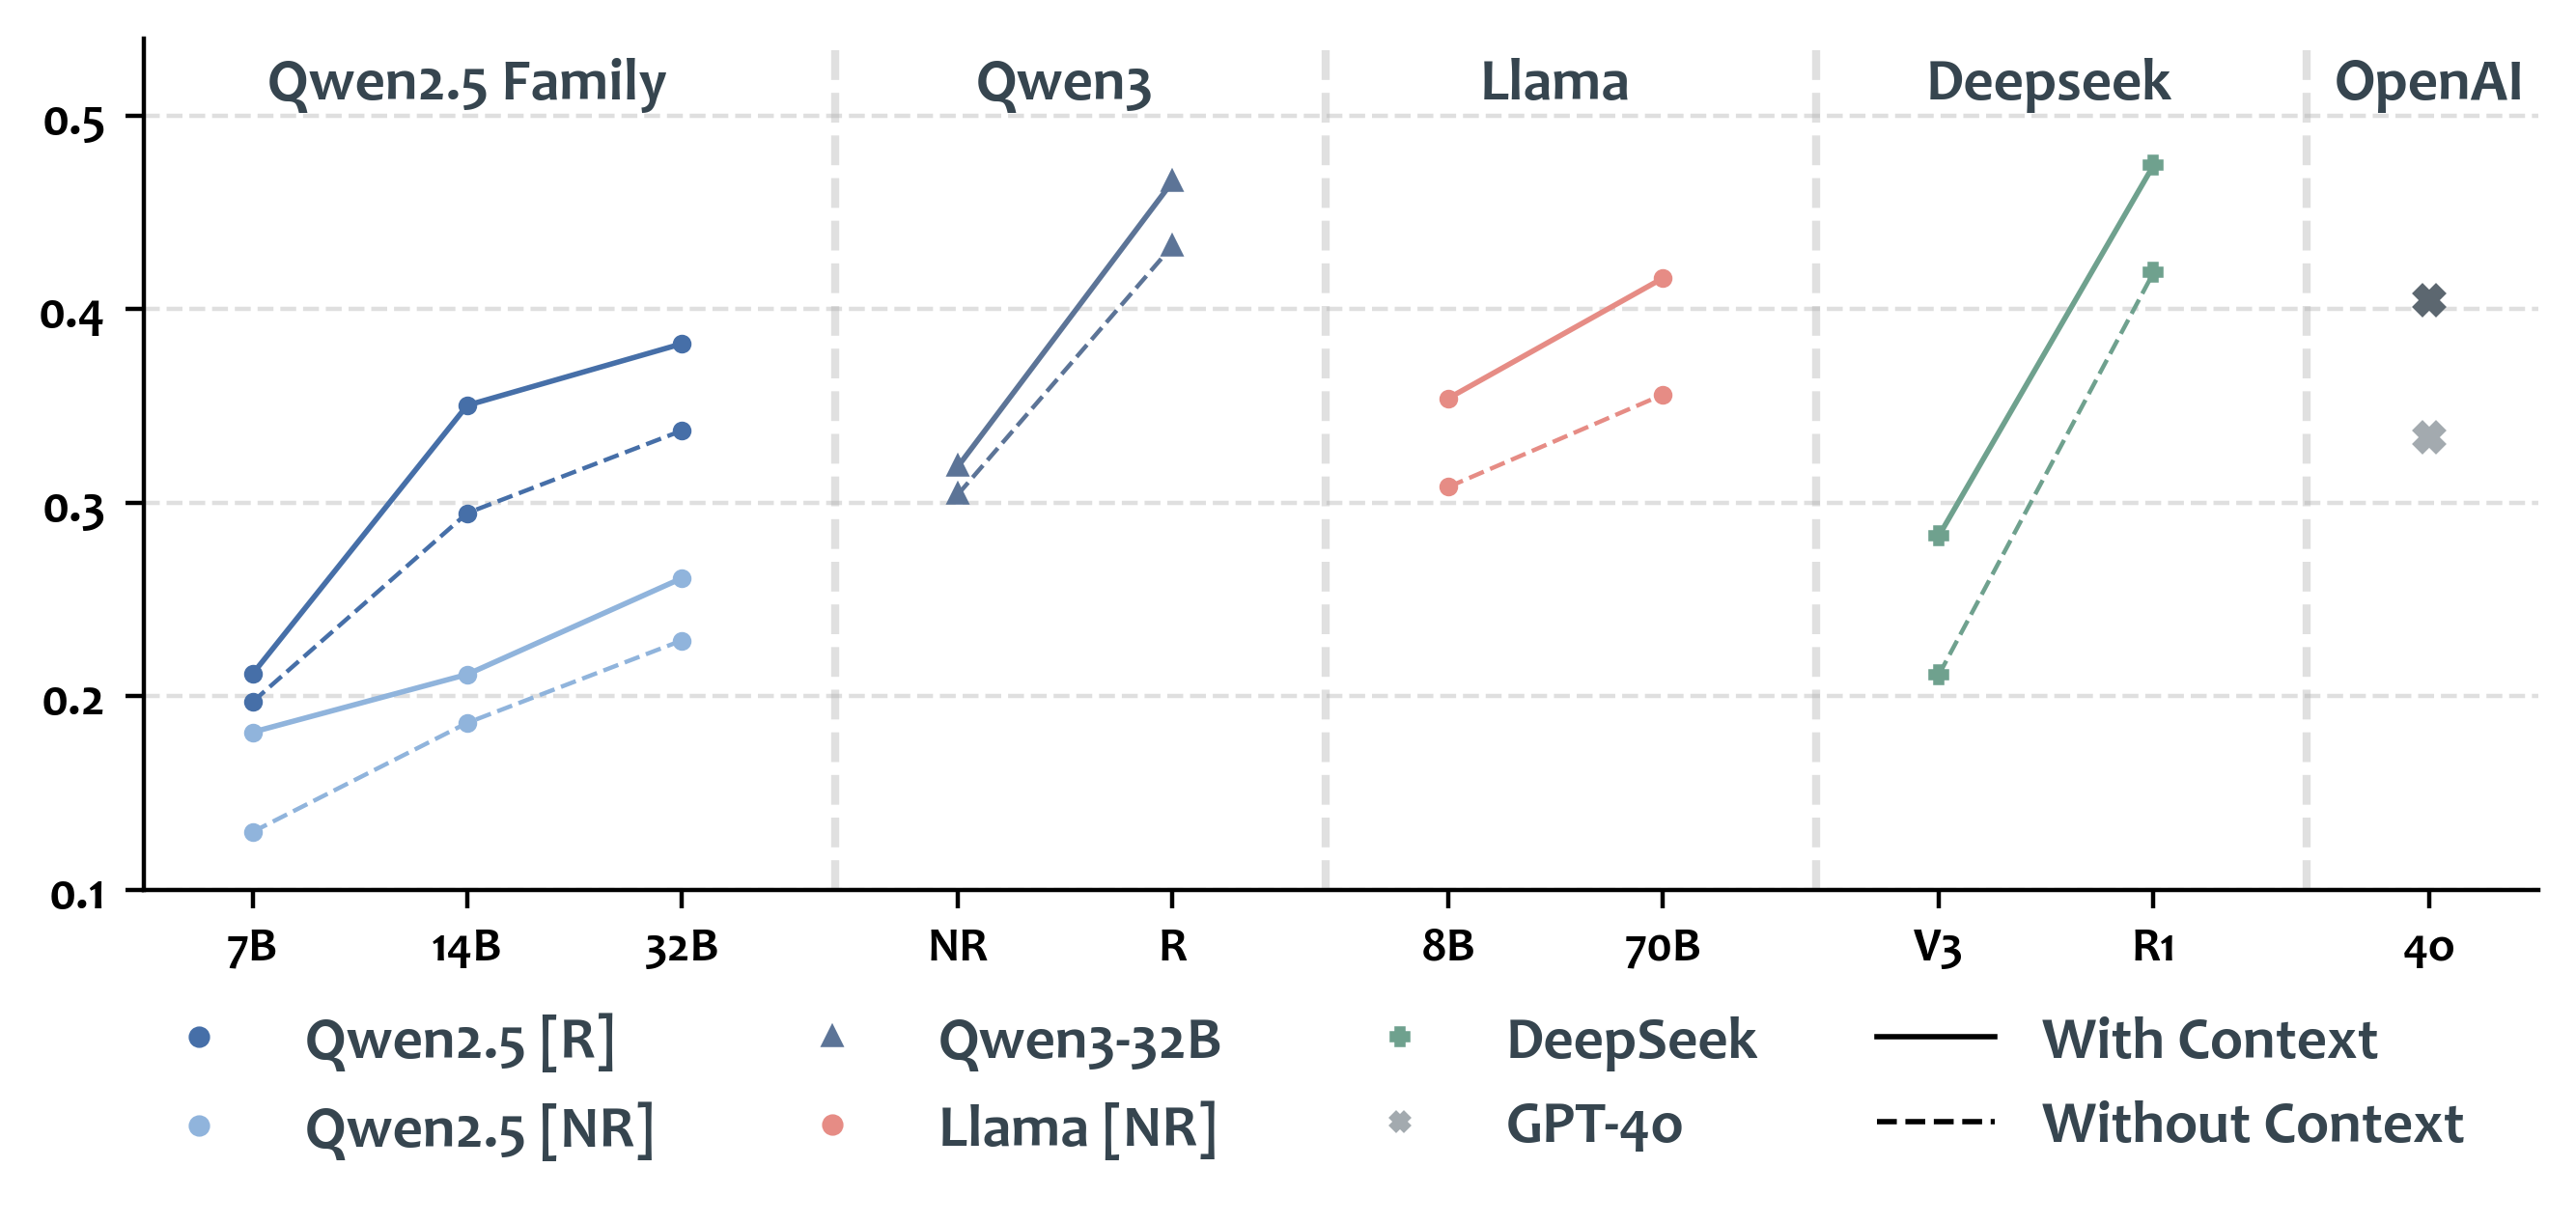

In [5]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D
import numpy as np
from collections import defaultdict
import json

import matplotlib.pyplot as plt
from matplotlib import font_manager as fm


plt.rcParams.update({
    "font.family": "Candara",
    "font.size": 11,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "xtick.labelsize": 9.5,
    "ytick.labelsize": 9.5,
    "font.weight": "bold"
})

# print("Using font:", candara_font.get_name())


model_map = {
    "r1-qn-7b": {"size": 7, "reasoning": True, "family": "Qwen", "display_name": "Qwen [R] 7B"},
    "r1-qn-14b": {"size": 14, "reasoning": True, "family": "Qwen", "display_name": "Qwen [R] 14B"},
    "r1-qn-32b": {"size": 32, "reasoning": True, "family": "Qwen", "display_name": "Qwen [R] 32B"},
    "r1-lm-8b": {"size": 9, "reasoning": True, "family": "Llama", "display_name": "Llama [R] 8B"},
    "r1-lm-70b": {"size": 70, "reasoning": True, "family": "Llama", "display_name": "Llama [R] 70B"},
    "qn-7b": {"size": 7, "reasoning": False, "family": "Qwen", "display_name": "Qwen [NR] 7B"},
    "qn-14b": {"size": 14, "reasoning": False, "family": "Qwen", "display_name": "Qwen [NR] 14B"},
    "qn-32b": {"size": 32, "reasoning": False, "family": "Qwen", "display_name": "Qwen [NR] 32B"},
    "qn3-32b": {"size": 32, "reasoning": True, "family": "Qwen", "special": True, "display_name": "Qwen3 [R] 32B"},
    "qn3-32b-0": {"size": 32, "reasoning": False, "family": "Qwen", "special": True, "display_name": "Qwen3 [NR] 32B"},
    "lm-8b": {"size": 9, "reasoning": False, "family": "Llama", "display_name": "Llama [NR] 8B"},
    "lm-70b": {"size": 70, "reasoning": False, "family": "Llama", "display_name": "Llama [NR] 70B"},
    "ds-v3": {"size": 671, "reasoning": False, "family": "DeepSeek", "special": True, "display_name": "DeepSeek-V3 671B"},
    "ds-r1": {"size": 671, "reasoning": True, "family": "DeepSeek", "special": True, "display_name": "DeepSeek-R1 671B"},
    "4o": {"size": 800, "reasoning": None, "family": "OpenAI", "special": True, "display_name": "GPT-4o"},
}

COLOR_MAP = {
    ("Qwen", True): "#466FA8",       # Dark blue
    ("Qwen", False): "#90B4DC",      # Lighter blue
    ("Llama", False): "#E68C85",     # Dark pink (Llama [NR])
    ("Llama", True): "#F7C6C3",      # Light pink (Llama [R] - if present)
}

SPECIAL_MARKERS_COLORS = {
    "ds-r1": ("P", "#6FA18E"),       # DeepSeek-R1
    "ds-v3": ("D", "#B0D8D5"),       # DeepSeek-V3
    "4o": ("X", "#A3AAAF"),          # GPT-4o
    "qn3-32b": ("^", "#5C7497"),     # Qwen3 [R]
    "qn3-32b-0": ("v", "#9ABFDB"),   # Qwen3 [NR]
}

def compress_model_size(size):
    return {671: 100, 800: 120}.get(size, size)

def prepare_plot_data(parsed_data, model_map):
    cwe_metrics = defaultdict(lambda: defaultdict(dict))
    special_models_data = defaultdict(lambda: defaultdict(dict))

    for model_data in parsed_data:
        model_name = model_data["model"]
        if model_name not in model_map:
            continue
        info = model_map[model_name]
        size = info["size"]
        family = info["family"]
        reasoning = info["reasoning"]
        special = info.get("special", False)
        if size is None:
            continue
        for row in model_data["data"]:
            if len(row) < 6:
                continue
            try:
                cwe_id = int(row[0].split("-")[1])
                if cwe_id in [435, 697]:
                    continue

                recall = float(row[2])
                accuracy = float(row[3])
                f1 = float(row[4])
                pair_accuracy_rate = float(row[5]) 

                if special:
                    special_models_data[cwe_id][model_name] = {
                        "recall": recall, "accuracy": accuracy, "f1": f1,
                        "pair_accuracy_rate": pair_accuracy_rate,
                        "total_instances": float(row[1]),
                        "size": size, "family": family, "reasoning": reasoning,
                    }
                else:
                    cwe_metrics[(family, reasoning)][cwe_id][size] = {
                        "recall": recall, "accuracy": accuracy, "f1": f1,
                        "pair_accuracy_rate": pair_accuracy_rate,
                        "total_instances": float(row[1]),
                    }
            except Exception as e:
                continue
    return {"param_data": dict(cwe_metrics), "special_data": dict(special_models_data)}

def calculate_overall_pair_accuracy(prepared_data, model_map):
    overall_accuracies = {}

    consolidated_data = defaultdict(dict)

    for (family, reasoning), cwe_metrics_by_cwe_id in prepared_data["param_data"].items():
        for cwe_id, metrics_by_size in cwe_metrics_by_cwe_id.items():
            for size, metrics in metrics_by_size.items():
                model_name = next(
                    (m_name for m_name, m_info in model_map.items()
                     if m_info.get("family") == family and m_info.get("reasoning") == reasoning and m_info.get("size") == size and not m_info.get("special")),
                    None
                )
                if model_name:
                    consolidated_data[model_name][cwe_id] = {
                        "total_instances": metrics["total_instances"],
                        "pair_accuracy_rate": metrics["pair_accuracy_rate"]
                    }

    for cwe_id, models_data_for_cwe in prepared_data["special_data"].items():
        for model_name, metrics in models_data_for_cwe.items():
            # Check if this model is in model_map and is indeed special
            if model_name in model_map and model_map[model_name].get("special"):
                consolidated_data[model_name][cwe_id] = {
                    "total_instances": metrics["total_instances"],
                    "pair_accuracy_rate": metrics["pair_accuracy_rate"]
                }

    for model_name, cwe_data_for_model in consolidated_data.items():
        total_paired_instances = 0
        total_all_instances = 0

        for cwe_id, metrics in cwe_data_for_model.items():
            total_paired_instances += metrics["total_instances"] * metrics["pair_accuracy_rate"]
            total_all_instances += metrics["total_instances"]

        if total_all_instances > 0:
            overall_accuracies[model_name] = total_paired_instances / total_all_instances
        else:
            overall_accuracies[model_name] = 0.0 # Or np.nan if you prefer to mark it as not applicable

    return overall_accuracies

def plot_compact_grouped_pair_accuracy(overall_acc_w, overall_acc_n, model_map):
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    import numpy as np

    fig, ax = plt.subplots(figsize=(8, 3.5), dpi=400)

    x_labels = []
    x_positions = {}
    current_x = 0

    separator_x_coords = []
    
    def assign_x_labels(group_labels, family_name, first_in_family=False):
        nonlocal current_x
        positions = []
        for lbl in group_labels:
            x_labels.append(lbl)
            x_positions[lbl] = current_x
            positions.append(current_x)
            current_x += 0.035  
        if family_name and family_name != "OpenAI":
            separator_x_coords.append(current_x + 0.005)
        current_x += 0.01 
        return positions

    def get_y_values(models, context_data):
        return [context_data.get(m, float('nan')) for m in models]

    # 1. Qwen
    qwen_sizes = ["7", "14", "32"]
    qwen_r_models = [f"r1-qn-{s}b" for s in qwen_sizes]
    qwen_nr_models = [f"qn-{s}b" for s in qwen_sizes]
    qwen_pos = assign_x_labels(qwen_sizes, "Qwen")

    ax.plot(qwen_pos, get_y_values(qwen_r_models, overall_acc_w),
            color="#466FA8", linestyle='-', marker='o', linewidth=1, markersize=2.5)
    ax.plot(qwen_pos, get_y_values(qwen_nr_models, overall_acc_w),
            color="#90B4DC", linestyle='-', marker='o', linewidth=1, markersize=2.5)
    ax.plot(qwen_pos, get_y_values(qwen_r_models, overall_acc_n),
            color="#466FA8", linestyle='--', marker='o', linewidth=0.8, markersize=2.5)
    ax.plot(qwen_pos, get_y_values(qwen_nr_models, overall_acc_n),
            color="#90B4DC", linestyle='--', marker='o', linewidth=0.8, markersize=2.5)

    # 2. Qwen3
    qwen3_models_w = ["qn3-32b-0", "qn3-32b"]
    qwen3_labels = ["NR", "R"]
    qwen3_pos = assign_x_labels(qwen3_labels, "Qwen3")

    ax.plot(qwen3_pos, get_y_values(qwen3_models_w, overall_acc_w),
            color="#5C7497", linestyle='-', marker='^', linewidth=1, markersize=2.8)
    ax.plot(qwen3_pos, get_y_values(qwen3_models_w, overall_acc_n),
            color="#5C7497", linestyle='--', marker='^', linewidth=0.8, markersize=2.8)

    # 3. Llama
    llama_models_w = ["lm-8b", "lm-70b"]
    llama_labels = ["8", "70"]
    llama_pos = assign_x_labels(llama_labels, "Llama")

    ax.plot(llama_pos, get_y_values(llama_models_w, overall_acc_w),
            color="#E68C85", linestyle='-', marker='o', linewidth=1, markersize=2.5)
    ax.plot(llama_pos, get_y_values(llama_models_w, overall_acc_n),
            color="#E68C85", linestyle='--', marker='o', linewidth=0.8, markersize=2.5)

    # 4. DeepSeek
    ds_models_w = ["ds-v3", "ds-r1"]
    ds_labels = ["V3", "R1"]
    ds_pos = assign_x_labels(ds_labels, "DeepSeek")

    ax.plot(ds_pos, get_y_values(ds_models_w, overall_acc_w),
            color="#6FA18E", linestyle='-', marker='P', linewidth=1, markersize=3)
    ax.plot(ds_pos, get_y_values(ds_models_w, overall_acc_n),
            color="#6FA18E", linestyle='--', marker='P', linewidth=0.8, markersize=3)

    # 5. GPT-4o
    x_labels.append("4o")
    x_positions["4o"] = current_x
    x_4o = current_x
    current_x += 0.4
    assign_x_labels([], "OpenAI")

    val_w = overall_acc_w.get("4o", float('nan'))
    val_n = overall_acc_n.get("4o", float('nan'))
    if not np.isnan(val_w):
        ax.plot(x_4o, val_w, marker='X', color="#5C6770", markersize=5, linestyle='None')
    if not np.isnan(val_n):
        ax.plot(x_4o, val_n, marker='X', color="#A3AAAF", markersize=5, linestyle='None')

    for sep_x in separator_x_coords:
        ax.axvline(x=sep_x - 0.015, color='#E0E0E0', linestyle='--', linewidth=1.5, zorder=0)

    ax.set_xticks(list(x_positions.values()))
    formatted_x_labels = []
    for label in x_labels:
        if label.isdigit():
            formatted_x_labels.append(f"{label}B")
        else:
            formatted_x_labels.append(label)
    ax.set_xticklabels(formatted_x_labels, rotation=0, fontsize=9, weight='bold')

    ax.set_ylim(0.1, 0.54)
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    # Family labels
    y_label_pos = 0.53
    family_label_color = "#36454F"

    ax.text(np.mean([x_positions["7"], x_positions["32"]]), y_label_pos, 'Qwen2.5 Family', ha='center', va='top', fontsize=11, color=family_label_color, weight='bold')
    ax.text(np.mean([x_positions["NR"], x_positions["R"]]), y_label_pos, 'Qwen3', ha='center', va='top', fontsize=11, color=family_label_color, weight='bold')
    ax.text(np.mean([x_positions["8"], x_positions["70"]]), y_label_pos, 'Llama', ha='center', va='top', fontsize=11, color=family_label_color, weight='bold')
    ax.text(np.mean([x_positions["V3"]+0.001, x_positions["R1"]]), y_label_pos, 'Deepseek', ha='center', va='top', fontsize=11, color=family_label_color, weight='bold')
    ax.text(x_positions["4o"], y_label_pos, 'OpenAI', ha='center', va='top', fontsize=11, color=family_label_color, weight='bold')

    # Legend
    consolidated_legend_handles = [
        Line2D([0], [0], color="#466FA8", marker='o', linestyle='None', label='Qwen2.5 [R]', markersize=3),
        Line2D([0], [0], color="#90B4DC", marker='o', linestyle='None', label='Qwen2.5 [NR]', markersize=3),
        Line2D([0], [0], color="#5C7497", marker='^', linestyle='None', label='Qwen3-32B', markersize=3),
        Line2D([0], [0], color="#E68C85", marker='o', linestyle='None', label='Llama [NR]', markersize=3),
        Line2D([0], [0], color="#6FA18E", marker='P', linestyle='None', label='DeepSeek', markersize=3),
        Line2D([0], [0], color="#A3AAAF", marker='X', linestyle='None', label='GPT-4o', markersize=3),
        Line2D([0], [0], color='black', linestyle='-', label='With Context', linewidth=1),
        Line2D([0], [0], color='black', linestyle='--', label='Without Context', linewidth=1)
    ]
    fig.legend(
        handles=consolidated_legend_handles,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.01),
        ncol=4,
        fontsize=0.05,
        frameon=False,
        labelcolor=family_label_color,
        prop={'weight': 'bold'}
    )

    fig.subplots_adjust(bottom=0.25)
    plt.savefig("cwe_pair_accuracy.pdf", dpi=1200, bbox_inches="tight")
    plt.show()
    plt.close()



with open("parsed_data_with_con.json") as f:
    data_w = json.load(f)

with open("parsed_data_without_con.json") as f:
    data_n = json.load(f)

data_w_prepared = prepare_plot_data(data_w, model_map)
data_n_prepared = prepare_plot_data(data_n, model_map)

overall_pair_acc_w = calculate_overall_pair_accuracy(data_w_prepared, model_map)
overall_pair_acc_n = calculate_overall_pair_accuracy(data_n_prepared, model_map)


plot_compact_grouped_pair_accuracy(overall_pair_acc_w, overall_pair_acc_n, model_map)

In [8]:
overall_pair_acc_w

{'r1-qn-32b': 0.38207021276595743,
 'r1-qn-7b': 0.21142881022615534,
 'r1-qn-14b': 0.35024506666666666,
 'qn-14b': 0.21118766637089617,
 'qn-32b': 0.26089157054126,
 'qn-7b': 0.1813408,
 'lm-70b': 0.4159871111111111,
 'lm-8b': 0.35386233396584443,
 'ds-r1': 0.47426551418439716,
 'ds-v3': 0.28280159574468083,
 'qn3-32b': 0.46580248888888887,
 'qn3-32b-0': 0.3185318544809228,
 '4o': 0.40450762331838563}

In [9]:
overall_pair_acc_n

{'lm-70b': 0.35580204081632655,
 'lm-8b': 0.3080582938388626,
 'qn-7b': 0.12980186666666665,
 'qn-14b': 0.1861447695035461,
 'qn-32b': 0.22872455673758865,
 'r1-qn-14b': 0.294555900621118,
 'r1-qn-7b': 0.19700678605089536,
 'r1-qn-32b': 0.3371783496007099,
 'ds-v3': 0.21100398936170217,
 '4o': 0.33365000000000006,
 'ds-r1': 0.4188251996450754,
 'qn3-32b-0': 0.3040989361702128,
 'qn3-32b': 0.4326401595744681}

In [ ]:
for model in overall_pair_acc_w:
    if model in overall_pair_acc_n:
        diff = overall_pair_acc_w[model] - overall_pair_acc_n[model]
        print(f"{model}: {diff:.4f}")
    else:
        print(f"{model}: Only in with context data")

r1-qn-32b: 0.0449
r1-qn-7b: 0.0144
r1-qn-14b: 0.0557
qn-14b: 0.0250
qn-32b: 0.0322
qn-7b: 0.0515
lm-70b: 0.0602
lm-8b: 0.0458
ds-r1: 0.0554
ds-v3: 0.0718
qn3-32b: 0.0332
qn3-32b-0: 0.0144
4o: 0.0709
